# Protein Sequence Classification: Deep Learning

In [ ]:
# Check GPU for LSTM and BERT models to run
import torch
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


In [ ]:
import torch
device = "mps" if getattr(torch, 'has_mps', False)\
else 'gpu' if torch.cuda.is_available() else 'cpu'
print(device)

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm
import random

import tensorflow as tf
# tf.config.run_functions_eagerly(True)
import torch


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To ensure reproducibility
# for keras operations that use random numbers internally
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Loading cleaned protein sequence data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('train_new_ecod.csv')
test_data = pd. read_csv('test_new_ecod.csv')
val_data = pd.read_csv('val_new_ecod.csv')

## Deep Learning Methods

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
import tensorflow
from keras.models import Sequential, Model
from keras.layers import  Conv1D, MaxPooling1D, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, Add, concatenate
from keras.utils import to_categorical

from keras.layers import LSTM, Bidirectional, Dense, Embedding, Input # CuDNNLSTM
from keras.regularizers import l2
from keras.utils import plot_model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping

from keras.preprocessing import text, sequence
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.initializers import glorot_uniform

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [ ]:
# Transform labels to one-hot
lb = LabelBinarizer()
y_train = lb.fit_transform(train_data.classification)
y_val = lb.transform(val_data.classification)
y_test = lb.transform(test_data.classification)

In [ ]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
max_length = 512
train_seqs = train_data.clean_sequence.values

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_seqs)
#represent input data as word rank number sequences
X_train_encode = tokenizer.texts_to_sequences(train_seqs)
X_train_512 = pad_sequences(X_train_encode, padding='post', truncating='post', maxlen=max_length)
X_train_256 = pad_sequences(X_train_encode, padding='post', truncating='post', maxlen = 256) # max_length 256
X_train_100 = pad_sequences(X_train_encode, padding='post', truncating='post', maxlen = 100)  # max_length 100

In [ ]:
max_length = 512
test_seqs = test_data.clean_sequence.values

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(test_seqs)
#represent input data as word rank number sequences
X_test_encode = tokenizer.texts_to_sequences(test_seqs)
X_test_512 = pad_sequences(X_test_encode, padding='post', truncating='post', maxlen=max_length)
X_test_256 = pad_sequences(X_test_encode, padding='post', truncating='post', maxlen = 256) # max_length 256
X_test_100 = pad_sequences(X_test_encode, padding='post', truncating='post', maxlen = 100)  # max_length 100

In [ ]:
max_length = 512
val_seqs = val_data.clean_sequence.values

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(val_seqs)
#represent input data as word rank number sequences
X_val_encode = tokenizer.texts_to_sequences(val_seqs)
X_val_512 = pad_sequences(X_val_encode, padding='post', truncating='post', maxlen=max_length)
X_val_256 = pad_sequences(X_val_encode, padding='post', truncating='post', maxlen = 256) # max_length 256
X_val_100 = pad_sequences(X_val_encode, padding='post', truncating='post', maxlen = 100)  # max_length 100

In [ ]:
lengths = [len(s) for s in train_seqs]
max(lengths)

4128

In [ ]:
len(tokenizer.word_index)+1

21

In [ ]:
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight('balanced', classes = np.unique(train_data.classification) ,y = train_data.classification)

print(cw)

[10.60996764 17.62623656 22.30258503  7.91903382  3.39387164  3.74255708
 18.84183908  6.35364341 15.61180952  1.15277075  1.48280416 16.31084577
  1.41557858  4.85700741  5.1792733   3.10462121  1.03194208  0.82727227
 13.49168724 11.2662543  14.57102222  5.60423932  2.42311899  8.21674185
  9.03162534 17.07541667  0.07744502  0.32485929  0.22108571  5.84399287
  0.66595166 16.31084577 11.87855072  0.72086192 11.0386532   3.3216616
 10.40787302  8.81311828  0.39869634  7.18964912  0.80473245  1.22377006
  3.71709751  3.95951691 10.40787302  0.12960468  2.54145736  3.97391515
  3.38336429  7.91903382 17.91519126  1.80037342  5.20393651  0.73098774
  1.40105983 15.17814815  5.93927536 11.38361111 13.49168724  1.62381377
  0.49270815 12.85678431  1.04676884  1.36774301  1.39747656  0.38849153
 21.42797386  2.54738151  0.11075572  0.86253091  3.00227106  0.48808694
  0.33307731  0.69695578  1.50527089]


In [ ]:
class_weight_dict = dict(enumerate(cw))
class_weight_dict

{0: 10.609967637540453,
 1: 17.626236559139784,
 2: 22.302585034013607,
 3: 7.919033816425121,
 4: 3.393871635610766,
 5: 3.742557077625571,
 6: 18.84183908045977,
 7: 6.353643410852714,
 8: 15.611809523809525,
 9: 1.1527707454289733,
 10: 1.4828041610131162,
 11: 16.31084577114428,
 12: 1.4155785837651123,
 13: 4.857007407407408,
 14: 5.179273301737757,
 15: 3.104621212121212,
 16: 1.0319420837267863,
 17: 0.8272722684834721,
 18: 13.491687242798355,
 19: 11.266254295532645,
 20: 14.571022222222222,
 21: 5.604239316239316,
 22: 2.423118994826312,
 23: 8.216741854636592,
 24: 9.031625344352618,
 25: 17.075416666666666,
 26: 0.07744501925212009,
 27: 0.3248592944906857,
 28: 0.2210857104322611,
 29: 5.843992869875223,
 30: 0.6659516554946171,
 31: 16.31084577114428,
 32: 11.878550724637682,
 33: 0.7208619173262972,
 34: 11.038653198653199,
 35: 3.321661600810537,
 36: 10.407873015873015,
 37: 8.813118279569892,
 38: 0.39869633953544936,
 39: 7.189649122807017,
 40: 0.8047324496809033,
 

In [ ]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
# plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.xticks(np.arange(1, len(acc) + 1, step=1))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.xticks(np.arange(1, len(acc) + 1, step=1))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

In [ ]:
# plt.style.use('ggplot')

def plot_compare_history(history1, history2, history3):
  val_acc1 = history1.history['val_accuracy']
  val_acc2 = history2.history['val_accuracy']
  val_acc3 = history3.history['val_accuracy']
  val_loss1 = history1.history['val_loss']
  val_loss2 = history2.history['val_loss']
  val_loss3 = history3.history['val_loss']
  x = range(1, len(val_acc1) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, val_acc1, 'b', label='val-acc 512 ')
  plt.plot(x, val_acc2, 'r', label='val-acc 256')
  plt.plot(x, val_acc3, 'g', label='val-acc 100')
  plt.title('Validation accuracy for different sequence length')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(x, val_loss1, 'b', label='val-loss 512')
  plt.plot(x, val_loss2, 'r', label='val-loss 256')
  plt.plot(x, val_loss3, 'g', label='val-loss 100')
  plt.title('Validation loss for different sequence length')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

In [ ]:
from tensorflow.keras.callbacks import Callback


class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.epoch_accuracy = []
        self.epoch_loss = []
        self.epoch_f1_weighted = []
        self.epoch_f1_macro = []
        self.epoch_val_accuracy = []
        self.epoch_val_loss = []

    def on_train_begin(self, logs=None):
        self.epoch_accuracy = []
        self.epoch_loss = []
        self.epoch_f1_weighted = []
        self.epoch_f1_macro = []
        self.epoch_val_accuracy = []
        self.epoch_val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_accuracy.append(logs.get('accuracy'))
        self.epoch_loss.append(logs.get('loss'))

        # Predict on the validation data
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        # Validation accuracy
        val_acc = np.mean(val_predict == val_targ)
        self.epoch_val_accuracy.append(val_acc)

        # Validation loss
        val_loss = self.model.evaluate(self.validation_data[0], self.validation_data[1], verbose=0)[0]
        self.epoch_val_loss.append(val_loss)


        # Calculate F1 scores
        f1_weighted = f1_score(val_targ, val_predict, average='weighted')
        f1_macro = f1_score(val_targ, val_predict, average='macro')

        self.epoch_f1_weighted.append(f1_weighted)
        self.epoch_f1_macro.append(f1_macro)

### LSTM

#### EXPERIMENT 1

In [ ]:
embedding_dim = 8
top_classes = 75
max_length = 512

model_lstm1 = Sequential()
model_lstm1.add(Embedding(len(tokenizer.word_index)+1, 8, input_length=max_length))
# model_lstm1.add(CuDNNLSTM(128))
model_lstm1.add(LSTM(128, dropout = 0.2, recurrent_dropout=0.2)) # (CuDNNLSTM(128)) if CuDNNLSTM not available
model_lstm1.add(Dropout(0.2))
model_lstm1.add(Dense(top_classes,activation='softmax'))
model_lstm1.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
print(model_lstm1.summary())

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 8)            168       
                                                                 
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 75)                9675      
                                                                 
Total params: 79,987
Trainable params: 79,987
Non-trainable params: 0
_________________________________________________________________
None


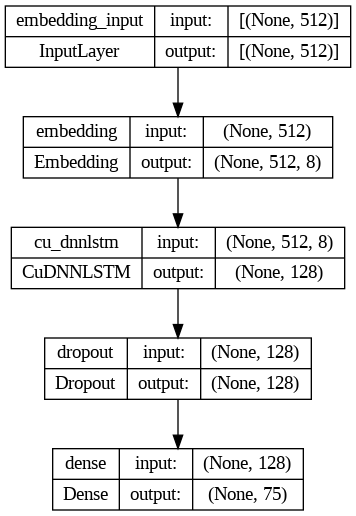

In [ ]:
plot_model(model_lstm1, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_lstm1.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

In [ ]:
history_lstm1 = model_lstm1.fit(X_train_512, y_train, batch_size=32, epochs=30, validation_data=(X_val_512, y_val), callbacks = early_stopping)


Epoch 1/30
3111/3111 [==============================] - 86s 24ms/step - loss: 3.2951 - accuracy: 0.1693 - val_loss: 3.1728 - val_accuracy: 0.1620
Epoch 2/30
3111/3111 [==============================] - 62s 20ms/step - loss: 3.1426 - accuracy: 0.1798 - val_loss: 3.0805 - val_accuracy: 0.1873
Epoch 3/30
3111/3111 [==============================] - 62s 20ms/step - loss: 3.0978 - accuracy: 0.1871 - val_loss: 3.0368 - val_accuracy: 0.2015
Epoch 4/30
3111/3111 [==============================] - 67s 22ms/step - loss: 3.0542 - accuracy: 0.2013 - val_loss: 3.0114 - val_accuracy: 0.2082
Epoch 5/30
3111/3111 [==============================] - 67s 22ms/step - loss: 3.0025 - accuracy: 0.2134 - val_loss: 2.9683 - val_accuracy: 0.2130
Epoch 6/30
3111/3111 [==============================] - 64s 21ms/step - loss: 2.9632 - accuracy: 0.2261 - val_loss: 2.8724 - val_accuracy: 0.2431
Epoch 7/30
3111/3111 [==============================] - 89s 28ms/step - loss: 2.8975 - accuracy: 0.2439 - val_loss: 2.8291 -

In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histlstm1_df = pd.DataFrame(history_lstm1.history)
# histlstm1_df.to_csv('hist_lstm1.csv', index = False)

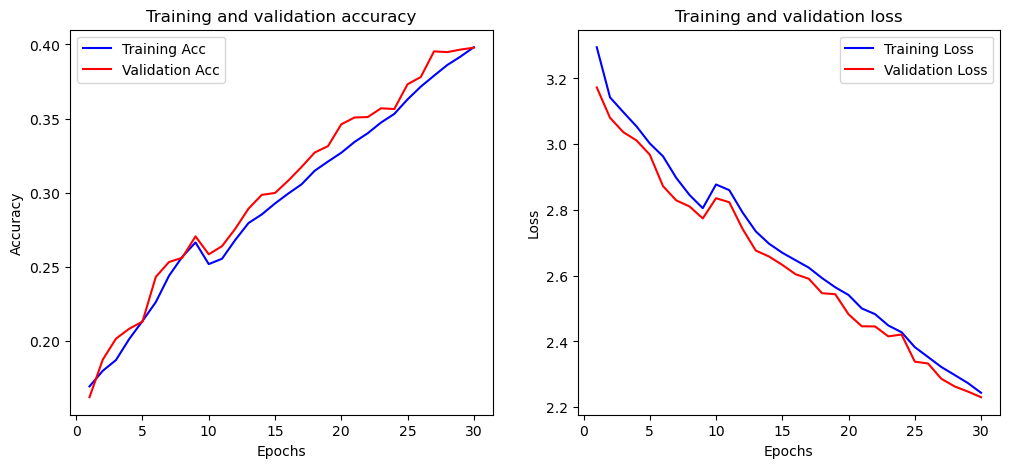

In [ ]:
plot_history(history_lstm1)


In [ ]:
test_loss, test_acc = model_lstm1.evaluate(X_test_512, y_test, verbose=1)
print("Test Accuracy: ",test_acc)
print("Test Loss: ",test_loss)

865/865 [==============================] - 13s 15ms/step - loss: 2.2952 - accuracy: 0.3870
Test Accuracy:  0.3870082902908325
Test Loss:  2.295152521133423



In [ ]:
train_pred_lstm1 = model_lstm1.predict(X_train_512)
test_pred_lstm1 = model_lstm1.predict(X_test_512)
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_lstm1, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_lstm1, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_lstm1, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_lstm1, axis=1), average = 'macro')))

865/865 [==============================] - 6s 7ms/step
train-acc = 0.3980857062493094
test-acc = 0.38700828119914656
test f1-score = 0.3430572215830823
test f1-score (macro) = 0.1574398656042



#### EXPERIMENT 2

In [ ]:
embedding_dim = 8
top_classes = 75
max_length = 256

model_lstm2 = Sequential()
model_lstm2.add(Embedding(len(tokenizer.word_index)+1, 8, input_length=max_length))
model_lstm2.add(CuDNNLSTM(128))
# model_lstm2.add(LSTM(128, dropout = 0.2, recurrent_dropout=0.2)) # (CuDNNLSTM(128)) if CuDNNLSTM not available
model_lstm2.add(Dropout(0.2))
model_lstm2.add(Dense(top_classes,activation='softmax'))
model_lstm2.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
print(model_lstm2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 8)            168       
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               70656     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 75)                9675      
                                                                 
Total params: 80499 (314.45 KB)
Trainable params: 80499 (314.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


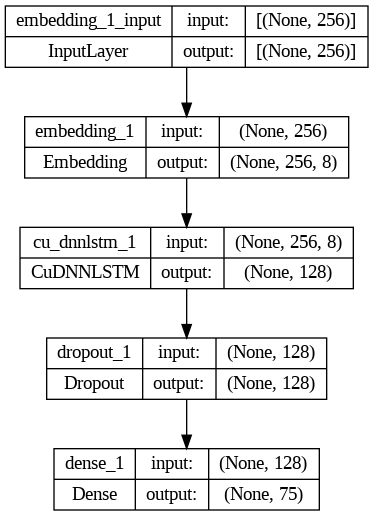

In [ ]:
plot_model(model_lstm2, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_lstm2.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

In [ ]:
history_lstm2 = model_lstm2.fit(X_train_256, y_train, batch_size=32, epochs=30, validation_data=(X_val_256, y_val), callbacks = early_stopping)



Epoch 1/30
3111/3111 [==============================] - 42s 13ms/step - loss: 3.1444 - accuracy: 0.1703 - val_loss: 3.0804 - val_accuracy: 0.1758
Epoch 2/30
3111/3111 [==============================] - 39s 13ms/step - loss: 3.0956 - accuracy: 0.1783 - val_loss: 3.0547 - val_accuracy: 0.1821
Epoch 3/30
3111/3111 [==============================] - 40s 13ms/step - loss: 3.0369 - accuracy: 0.1851 - val_loss: 3.0184 - val_accuracy: 0.1894
Epoch 4/30
3111/3111 [==============================] - 38s 12ms/step - loss: 3.0583 - accuracy: 0.1903 - val_loss: 3.0237 - val_accuracy: 0.1942
Epoch 5/30
3111/3111 [==============================] - 39s 12ms/step - loss: 3.0080 - accuracy: 0.2005 - val_loss: 2.9339 - val_accuracy: 0.2101
Epoch 6/30
3111/3111 [==============================] - 40s 13ms/step - loss: 2.9834 - accuracy: 0.2112 - val_loss: 2.8793 - val_accuracy: 0.2227
Epoch 7/30
3111/3111 [==============================] - 39s 13ms/step - loss: 2.8531 - accuracy: 0.2286 - val_loss: 2.7815 

In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histlstm2_df = pd.DataFrame(history_lstm2.history)
# histlstm2_df.to_csv('hist_lstm2.csv', index = False)

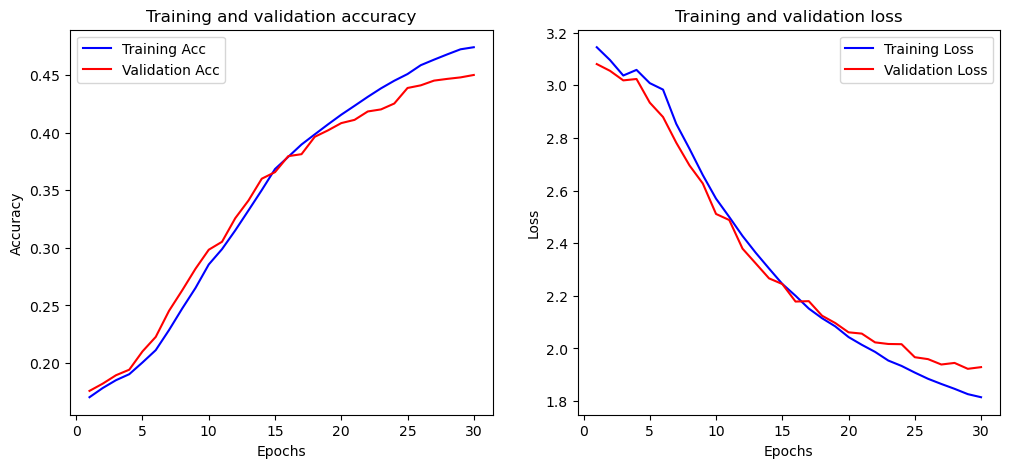

In [ ]:
plot_history(history_lstm2)


In [ ]:
# test_loss2, test_acc2 = model_lstm2.evaluate(X_test_256, y_test, verbose=1)
# print("Test Accuracy: ",test_acc2)
# print("Test Loss: ",test_loss2

865/865 [==============================] - 11s 12ms/step - loss: 1.9230 - accuracy: 0.4004
Test Accuracy:  0.40044608664512634
Test Loss:  1.9230401515960693



In [ ]:
train_pred_lstm2 = model_lstm2.predict(X_train_256)
test_pred_lstm2 = model_lstm2.predict(X_test_256)
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_lstm2, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_lstm2, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_lstm2, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_lstm2, axis=1), average = 'macro')))

865/865 [==============================] - 6s 7ms/step
train-acc = 0.4742603011642742
test-acc = 0.40044609988066395
test f1-score = 0.37461119266896205
test f1-score (macro) = 0.25466896205111926



#### EXPERIMENT 3

In [ ]:
embedding_dim = 8
top_classes = 75
max_length = 100

model_lstm3 = Sequential()
model_lstm3.add(Embedding(len(tokenizer.word_index)+1, 8, input_length=max_length))
model_lstm3.add(CuDNNLSTM(128))
# model_lstm3.add(LSTM(128, dropout = 0.2, recurrent_dropout=0.2)) # (CuDNNLSTM(128)) if CuDNNLSTM not available
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(top_classes,activation='softmax'))
model_lstm3.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
print(model_lstm3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 8)            168       
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 128)               70656     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 75)                9675      
                                                                 
Total params: 80499 (314.45 KB)
Trainable params: 80499 (314.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


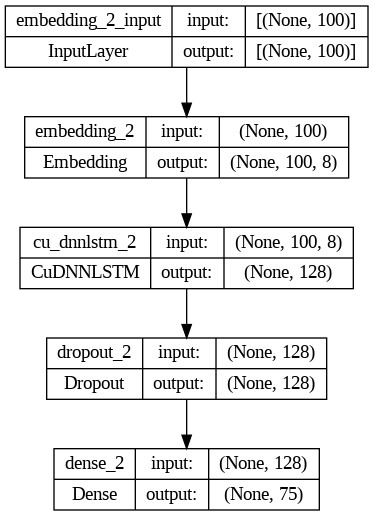

In [ ]:
plot_model(model_lstm3, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_lstm2.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

# usage
metrics_callback = MetricsCallback(validation_data=(X_val_100, y_val))

In [ ]:
history_lstm3 = model_lstm3.fit(X_train_100, y_train, batch_size=32, epochs=30, validation_data=(X_val_100, y_val), callbacks = [metrics_callback, early_stopping])


Epoch 1/30
3111/3111 [==============================] - 28s 8ms/step - loss: 3.1826 - accuracy: 0.1673 - val_loss: 3.0450 - val_accuracy: 0.1861
Epoch 2/30
3111/3111 [==============================] - 25s 8ms/step - loss: 2.9781 - accuracy: 0.2043 - val_loss: 2.9007 - val_accuracy: 0.2130
Epoch 3/30
3111/3111 [==============================] - 26s 8ms/step - loss: 2.8290 - accuracy: 0.2370 - val_loss: 2.7424 - val_accuracy: 0.2534
Epoch 4/30
3111/3111 [==============================] - 27s 9ms/step - loss: 2.6933 - accuracy: 0.2741 - val_loss: 2.6125 - val_accuracy: 0.2898
Epoch 5/30
3111/3111 [==============================] - 25s 8ms/step - loss: 2.5714 - accuracy: 0.3034 - val_loss: 2.5223 - val_accuracy: 0.3153
Epoch 6/30
3111/3111 [==============================] - 27s 9ms/step - loss: 2.4692 - accuracy: 0.3277 - val_loss: 2.4240 - val_accuracy: 0.3336
Epoch 7/30
3111/3111 [==============================] - 47s 15ms/step - loss: 2.3798 - accuracy: 0.3508 - val_loss: 2.3528 - val_a

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback.epoch_accuracy)
std_accuracy = np.std(metrics_callback.epoch_accuracy)
mean_loss = np.mean(metrics_callback.epoch_loss)
std_loss = np.std(metrics_callback.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback.epoch_val_loss)
std_val_loss = np.std(metrics_callback.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.422 ± 0.098
Training Loss (mean ± std): 2.104 ± 0.397
Validation Accuracy (mean ± std): 0.410 ± 0.082
Validation Loss (mean ± std): 2.182 ± 0.300
Validation F1 Score (weighted) (mean ± std): 0.402 ± 0.197
Validation F1 Score (macro) (mean ± std): 0.310 ± 0.202



In [ ]:
# Lists to store the training and validation loss and accuracy
train_acc = history_lstm3.history['accuracy']
train_loss = history_lstm3.history['loss']

val_acc = history_lstm3.history['val_accuracy']
val_loss = history_lstm3.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.422 ± 0.098
Training Loss (mean ± std): 2.104 ± 0.397
Validation Accuracy (mean ± std): 0.410 ± 0.083
Validation Loss (mean ± std): 2.182 ± 0.300


In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histlstm3_df = pd.DataFrame(history_lstm3.history)
# histlstm3_df.to_csv('hist_lstm3.csv', index = False)

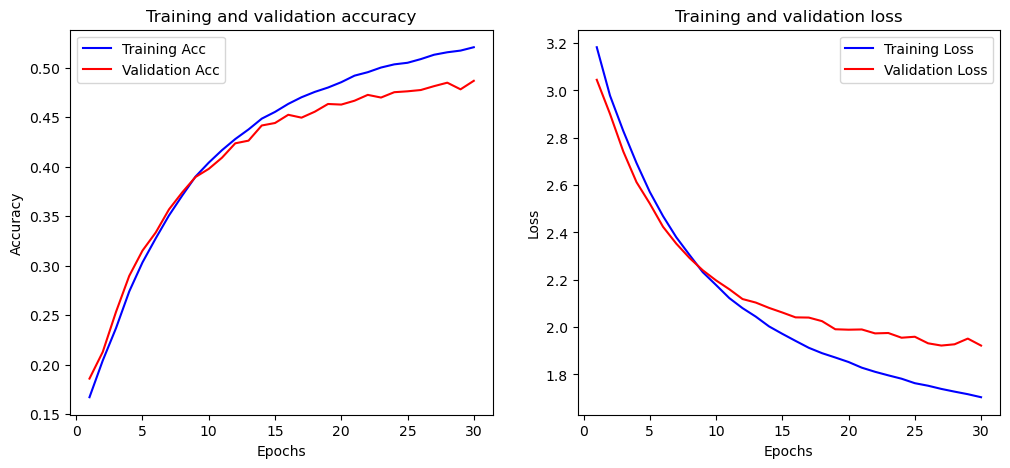

In [ ]:
plot_history(history_lstm3)

In [ ]:
test_loss3, test_acc3 = model_lstm3.evaluate(X_test_100, y_test, verbose=1)
print("Test Accuracy: ",test_acc3)
print("Test Loss: ",test_loss3)

865/865 [==============================] - 7s 8ms/step - loss: 1.9236 - accuracy: 0.4338
Test Accuracy:  0.4338764219284058
Test Loss:  1.9235647916793823



In [ ]:
train_pred_lstm3 = model_lstm3.predict(X_train_100)
test_pred_lstm3 = model_lstm3.predict(X_test_100)
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_lstm3, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_lstm3, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_lstm3, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_lstm3, axis=1), average = 'macro')))

865/865 [==============================] - 5s 5ms/step
train-acc = 0.520605784202437
test-acc =  0.4338764219284058
test f1-score = 0.3865535942985635
test f1-score (macro) = 0.26511192625466896



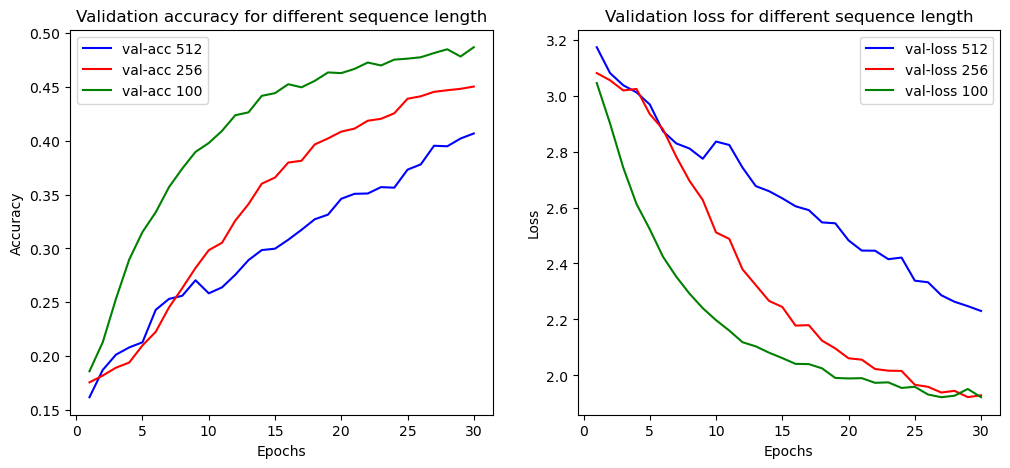

In [ ]:
# plot_compare_history(history_lstm1, history_lstm2, history_lstm3)

# Lists for storing loss and accuracy values
epochs = list(range(1, 31))

train_loss = [3.2951, 3.1426, 3.0978, 3.0542, 3.0025, 2.9632, 2.8975, 2.8456, 2.8054, 2.8775,
              2.8603, 2.7925, 2.7349, 2.6974, 2.6698, 2.6471, 2.6245, 2.5928, 2.5647, 2.5413,
              2.5004, 2.4831, 2.4486, 2.4281, 2.3827, 2.3526, 2.3223, 2.2981, 2.2735, 2.2438]

train_acc = [0.1693, 0.1798, 0.1871, 0.2013, 0.2134, 0.2261, 0.2439, 0.2567, 0.2664, 0.2518,
             0.2554, 0.2681, 0.2795, 0.2853, 0.2927, 0.2994, 0.3056, 0.3148, 0.3210, 0.3269,
             0.3342, 0.3401, 0.3473, 0.3531, 0.3629, 0.3715, 0.3789, 0.3861, 0.3918, 0.3981]

val_loss = [3.1728, 3.0805, 3.0368, 3.0114, 2.9683, 2.8724, 2.8291, 2.8107, 2.7743, 2.8357,
            2.8235, 2.7426, 2.6765, 2.6584, 2.6329, 2.6045, 2.5907, 2.5468, 2.5436, 2.4826,
            2.4461, 2.4457, 2.4154, 2.4211, 2.3386, 2.3329, 2.2865, 2.2632, 2.2476, 2.2303]

val_acc = [0.1620, 0.1873, 0.2015, 0.2082, 0.2130, 0.2431, 0.2532, 0.2561, 0.2705, 0.2584,
           0.2639, 0.2756, 0.2892, 0.2985, 0.2998, 0.3081, 0.3173, 0.3271, 0.3314, 0.3461,
           0.3507, 0.3510, 0.3569, 0.3564, 0.3731, 0.3780, 0.3953, 0.3948, 0.4020, 0.4067]


train_loss2 = [3.1444, 3.0956, 3.0369, 3.0583, 3.0080, 2.9834, 2.8531, 2.7583, 2.6589, 2.5691,
              2.4993, 2.4273, 2.3632, 2.3036, 2.2452, 2.2000, 2.1515, 2.1148, 2.0837, 2.0432,
              2.0138, 1.9869, 1.9539, 1.9335, 1.9082, 1.8846, 1.8650, 1.8465, 1.8263, 1.8146]

train_acc2 = [0.1703, 0.1783, 0.1851, 0.1903, 0.2005, 0.2112, 0.2286, 0.2474, 0.2652, 0.2856,
             0.2989, 0.3152, 0.3326, 0.3502, 0.3685, 0.3791, 0.3898, 0.3986, 0.4073, 0.4157,
             0.4234, 0.4312, 0.4386, 0.4452, 0.4510, 0.4587, 0.4635, 0.4681, 0.4725, 0.4743]

val_loss2 = [3.0804, 3.0547, 3.0184, 3.0237, 2.9339, 2.8793, 2.7815, 2.6951, 2.6268, 2.5109,
            2.4878, 2.3791, 2.3228, 2.2662, 2.2447, 2.1781, 2.1796, 2.1243, 2.0964, 2.0612,
            2.0563, 2.0230, 2.0169, 2.0161, 1.9666, 1.9593, 1.9389, 1.9449, 1.9225, 1.9289]

val_acc2 = [0.1758, 0.1821, 0.1894, 0.1942, 0.2101, 0.2227, 0.2453, 0.2632, 0.2819, 0.2984,
           0.3053, 0.3258, 0.3412, 0.3601, 0.3658, 0.3797, 0.3814, 0.3965, 0.4021, 0.4084,
           0.4112, 0.4185, 0.4203, 0.4254, 0.4389, 0.4412, 0.4453, 0.4468, 0.4481, 0.4502]


train_loss3 = [3.1826, 2.9781, 2.8290, 2.6933, 2.5714, 2.4692, 2.3798, 2.3050, 2.2321, 2.1781, 2.1228, 2.0803, 2.0444, 2.0031, 1.9718, 1.9419, 1.9127, 1.8900, 1.8717, 1.8527, 1.8287, 1.8113, 1.7963, 1.7821, 1.7632, 1.7525, 1.7390, 1.7275, 1.7167, 1.7039]
train_acc3 = [0.1673, 0.2043, 0.2370, 0.2741, 0.3034, 0.3277, 0.3508, 0.3709, 0.3900, 0.4041, 0.4167, 0.4279, 0.4376, 0.4485, 0.4553, 0.4634, 0.4701, 0.4755, 0.4799, 0.4853, 0.4919, 0.4954, 0.5001, 0.5033, 0.5049, 0.5086, 0.5130, 0.5155, 0.5172, 0.5206]
val_loss3 = [3.0450, 2.9007, 2.7424, 2.6125, 2.5223, 2.4240, 2.3528, 2.2922, 2.2402, 2.1975, 2.1602, 2.1187, 2.1038, 2.0813, 2.0619, 2.0413, 2.0404, 2.0253, 1.9910, 1.9892, 1.9902, 1.9736, 1.9752, 1.9553, 1.9594, 1.9317, 1.9222, 1.9275, 1.9516, 1.9221]
val_acc3 = [0.1861, 0.2130, 0.2534, 0.2898, 0.3153, 0.3336, 0.3569, 0.3741, 0.3896, 0.3978, 0.4091, 0.4236, 0.4263, 0.4416, 0.4441, 0.4524, 0.4495, 0.4555, 0.4633, 0.4627, 0.4666, 0.4725, 0.4698, 0.4752, 0.4761, 0.4774, 0.4813, 0.4848, 0.4781, 0.4867]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, val_acc, 'b-', label='val-acc 512')
plt.plot(epochs, val_acc2, 'r-', label='val-acc 256')
plt.plot(epochs, val_acc3, 'g-', label='val-acc 100')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation accuracy for different sequence length')


# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, 'b-', label='val-loss 512')
plt.plot(epochs, val_loss2, 'r-', label='val-loss 256')
plt.plot(epochs, val_loss3, 'g-', label='val-loss 100')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation loss for different sequence length')

plt.show()


### Multichannel CNN1D

##### EXPERIMENT 1

In [ ]:
# define model
def define_model(vocab_size,embedding_dim, channels,  filter_size, kernel_size, length, total_classes):
    inputs = {}
    embedding = {}
    conv = {}
    drop = {}
    pool = {}
    flat = {}
    for channel in range(1, channels + 1):
        inputs[channel] = Input(shape = (length,), dtype ='float64')
        embedding[channel] = Embedding(vocab_size, embedding_dim, input_length = length)(inputs[channel])
        conv[channel] = Conv1D(filters=filter_size[channel], kernel_size=kernel_size[channel], activation = 'relu')(embedding[channel])
        drop[channel] = Dropout(0.2)(conv[channel])
        pool[channel] = MaxPooling1D(pool_size = 2)(drop[channel])
        flat[channel] = Flatten()(pool[channel])
    merged = concatenate(list(flat.values()))
    dense = Dense(1120, activation = 'relu')(merged)
    outputs = Dense(total_classes, activation = 'softmax')(dense)       # softmax for multiclass classification

    model = Model(list(inputs.values()), outputs=outputs)

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    print(model.summary())
    # plot_model(model, show_shapes = True, to_file = 'multichannel.png')
    return model




In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 512

combine_model1 = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 512, 8)       168         ['input_1[0][0]']                
                                                                                              

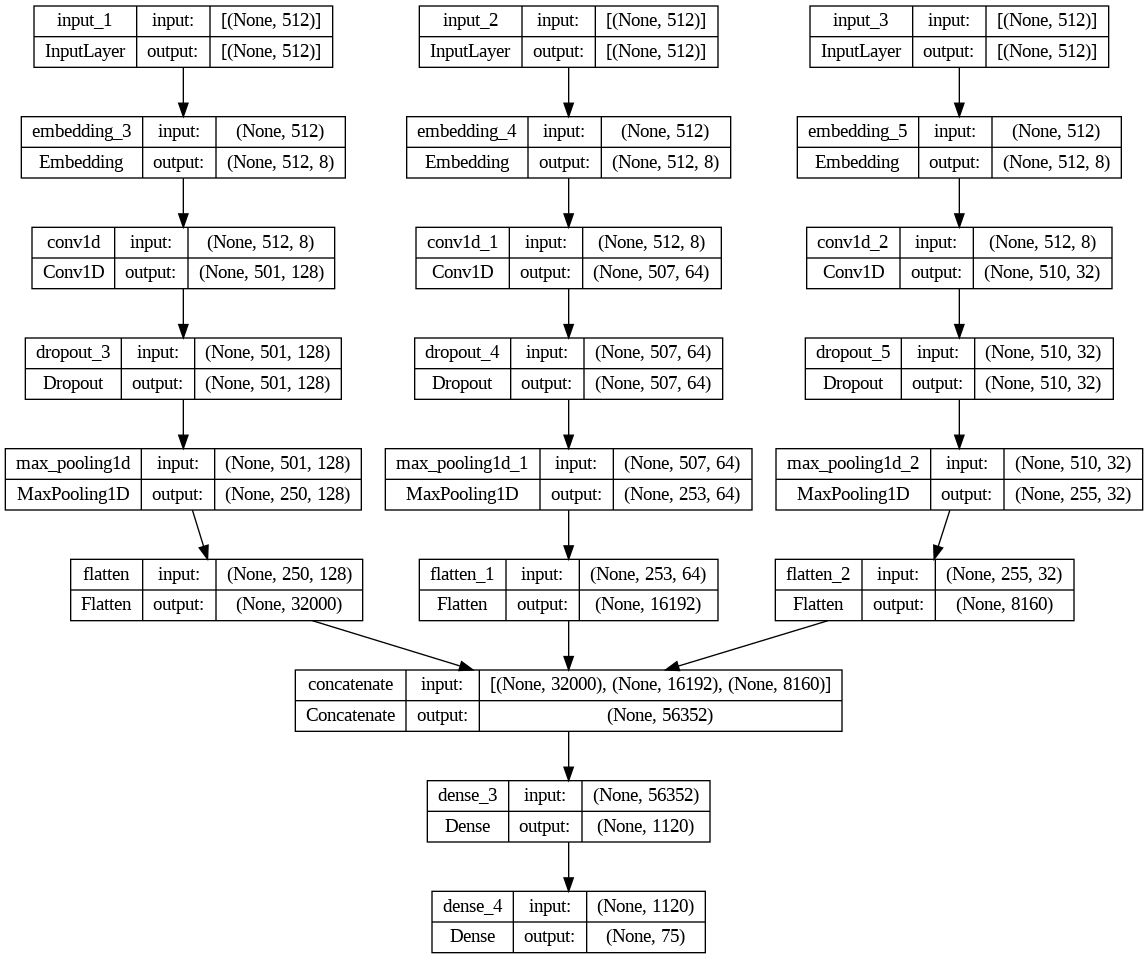

In [ ]:
plot_model(combine_model1, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/multichannel.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

metrics_callback_cnn = MetricsCallback(validation_data=([X_val_512, X_val_512, X_val_512], y_val))

In [ ]:
history_combine_model1 = combine_model1.fit([X_train_512, X_train_512, X_train_512], y_train, epochs = 20, batch_size = 128, validation_data=([X_val_512, X_val_512, X_val_512], y_val), callbacks = [metrics_callback_cnn, early_stopping], verbose = 1)

Epoch 1/20
641/641 [==============================] - 336s 521ms/step - loss: 2.1672 - accuracy: 0.4203 - val_loss: 1.8596 - val_accuracy: 0.5195
Epoch 2/20
641/641 [==============================] - 314s 489ms/step - loss: 1.4681 - accuracy: 0.5873 - val_loss: 1.5109 - val_accuracy: 0.6131
Epoch 3/20
641/641 [==============================] - 278s 434ms/step - loss: 0.7956 - accuracy: 0.7600 - val_loss: 1.3966 - val_accuracy: 0.6612
Epoch 4/20
641/641 [==============================] - 248s 387ms/step - loss: 0.4490 - accuracy: 0.8590 - val_loss: 1.3903 - val_accuracy: 0.6716
Epoch 5/20
641/641 [==============================] - 174s 272ms/step - loss: 0.3242 - accuracy: 0.8978 - val_loss: 1.3797 - val_accuracy: 0.6906
Epoch 6/20
641/641 [==============================] - 172s 268ms/step - loss: 0.2946 - accuracy: 0.9088 - val_loss: 1.3747 - val_accuracy: 0.6960
Epoch 7/20
641/641 [==============================] - 167s 261ms/step - loss: 0.2980 - accuracy: 0.9091 - val_loss: 1.3656 -

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback_cnn.epoch_accuracy)
std_accuracy = np.std(metrics_callback_cnn.epoch_accuracy)
mean_loss = np.mean(metrics_callback_cnn.epoch_loss)
std_loss = np.std(metrics_callback_cnn.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback_cnn.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback_cnn.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback_cnn.epoch_val_loss)
std_val_loss = np.std(metrics_callback_cnn.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback_cnn.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback_cnn.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback_cnn.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback_cnn.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.852 ± 0.136
Training Loss (mean ± std): 0.499 ± 0.512
Validation Accuracy (mean ± std): 0.686 ± 0.049
Validation Loss (mean ± std): 1.371 ± 0.135
Validation F1 Score (weighted) (mean ± std): 0.679 ± 0.056
Validation F1 Score (macro) (mean ± std): 0.516 ± 0.089


In [ ]:
train_acc = history_combine_model1.history['accuracy']
train_loss = history_combine_model1.history['loss']

val_acc = history_combine_model1.history['val_accuracy']
val_loss = history_combine_model1.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.852 ± 0.136
Training Loss (mean ± std): 0.499 ± 0.512
Validation Accuracy (mean ± std): 0.686 ± 0.049
Validation Loss (mean ± std): 1.371 ± 0.135


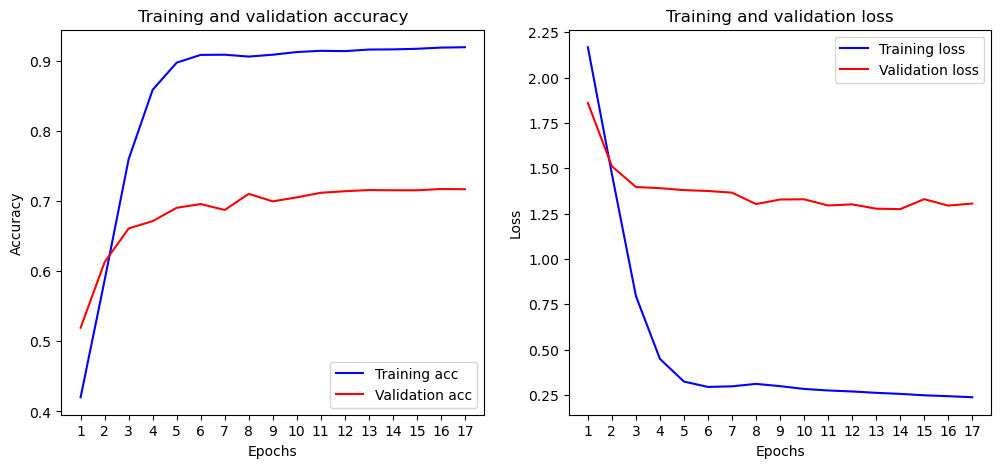

In [ ]:
plot_history(history_combine_model1)

In [ ]:
test_loss, test_acc = combine_model1.evaluate([X_test_512, X_test_512, X_test_512],y_test, verbose=1)
print("Test Accuracy: ",test_acc)
print("Test Loss: ",test_loss)

390/390 [==============================] - 5s 13ms/step - loss: 2.185 - accuracy: 0.5028
Test Accuracy:  0.5028437519073486
Test Loss:  2.1846885681152344



In [ ]:
train_pred_combine1 = combine_model1.predict([X_train_512, X_train_512, X_train_512])
test_pred_combine1 = combine_model1.predict([X_test_512, X_test_512, X_test_512])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_combine1, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_combine1, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_combine1, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_combine1, axis=1), average = 'macro')))

390/390 [==============================] - 5s 13ms/step
train-acc = 0.9198107903662672
test-acc = 0.5028437519073486
test f1-score = 0.4720959419763806
test f1-score (macro) = 0.40511192625466896



##### Experiment 1a with class weight

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 512

model_cnn1a = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 512, 8)       168         ['input_4[0][0]']                
                                                                                            

In [ ]:
metrics_callback_cnn1a = MetricsCallback(validation_data=([X_val_512, X_val_512, X_val_512], y_val))

In [ ]:
history_cnn1a = model_cnn1a.fit([X_train_512, X_train_512, X_train_512], y_train, validation_data=([X_val_512, X_val_512, X_val_512], y_val), epochs=20, batch_size=128, class_weight = class_weight_dict, callbacks = [metrics_callback_cnn1a, early_stopping])


Epoch 1/20
641/641 [==============================] - 245s 379ms/step - loss: 3.3672 - accuracy: 0.1305 - val_loss: 2.6708 - val_accuracy: 0.3304
Epoch 2/20
641/641 [==============================] - 145s 227ms/step - loss: 1.7913 - accuracy: 0.3446 - val_loss: 2.3178 - val_accuracy: 0.4273
Epoch 3/20
641/641 [==============================] - 147s 229ms/step - loss: 1.0198 - accuracy: 0.5125 - val_loss: 1.9450 - val_accuracy: 0.5169
Epoch 4/20
641/641 [==============================] - 145s 226ms/step - loss: 0.7096 - accuracy: 0.6263 - val_loss: 1.8275 - val_accuracy: 0.5504
Epoch 5/20
641/641 [==============================] - 145s 226ms/step - loss: 0.5727 - accuracy: 0.6987 - val_loss: 1.6519 - val_accuracy: 0.6015
Epoch 6/20
641/641 [==============================] - 145s 226ms/step - loss: 0.5135 - accuracy: 0.7467 - val_loss: 1.5503 - val_accuracy: 0.6193
Epoch 7/20
641/641 [==============================] - 144s 225ms/step - loss: 0.4431 - accuracy: 0.7838 - val_loss: 1.4918 -

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback_cnn1a.epoch_accuracy)
std_accuracy = np.std(metrics_callback_cnn1a.epoch_accuracy)
mean_loss = np.mean(metrics_callback_cnn1a.epoch_loss)
std_loss = np.std(metrics_callback_cnn1a.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback_cnn1a.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback_cnn1a.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback_cnn1a.epoch_val_loss)
std_val_loss = np.std(metrics_callback_cnn1a.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback_cnn1a.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback_cnn1a.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback_cnn1a.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback_cnn1a.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.649 ± 0.221
Training Loss (mean ± std): 0.905 ± 0.877
Validation Accuracy (mean ± std): 0.572 ± 0.103
Validation Loss (mean ± std): 1.803 ± 0.360
Validation F1 Score (weighted) (mean ± std): 0.585 ± 0.102
Validation F1 Score (macro) (mean ± std): 0.501 ± 0.085


In [ ]:
train_acc = history_cnn1a.history['accuracy']
train_loss = history_cnn1a.history['loss']

val_acc = history_cnn1a.history['val_accuracy']
val_loss = history_cnn1a.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.649 ± 0.221
Training Loss (mean ± std): 0.905 ± 0.877
Validation Accuracy (mean ± std): 0.572 ± 0.103
Validation Loss (mean ± std): 1.803 ± 0.360


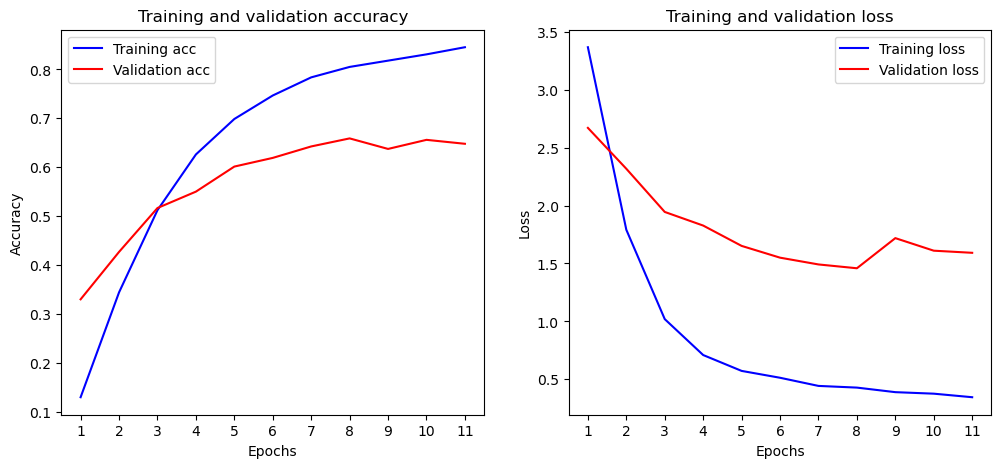

In [ ]:
plot_history(history_cnn1a)

In [ ]:
test_loss, test_acc = model_cnn1a.evaluate([X_test_512, X_test_512, X_test_512],y_test, verbose=1)
print("Test Accuracy: ",test_acc)
print("Test Loss: ",test_loss)

390/390 [==============================] - 5s 13ms/step - loss: 2.043 - accuracy: 0.4884
Test Accuracy:  0.4884494508137578
Test Loss:  2.0427982807159424



In [ ]:
train_pred_cnn1a = model_cnn1a.predict([X_train_512, X_train_512, X_train_512])
test_pred_cnn1a = model_cnn1a.predict([X_test_512, X_test_512, X_test_512])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_cnn1a, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_cnn1a, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_cnn1a, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_cnn1a, axis=1), average = 'macro')))

390/390 [==============================] - 5s 12ms/step
train-acc = 0.8625460579292843
test-acc = 0.4884494508137578
test f1-score = 0.4563123272801404
test f1-score (macro) = 0.38511192625466896



##### EXPERIMENT 2

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 256

combine_model2 = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 256, 8)       168         ['input_7[0][0]']                
                                                                                            

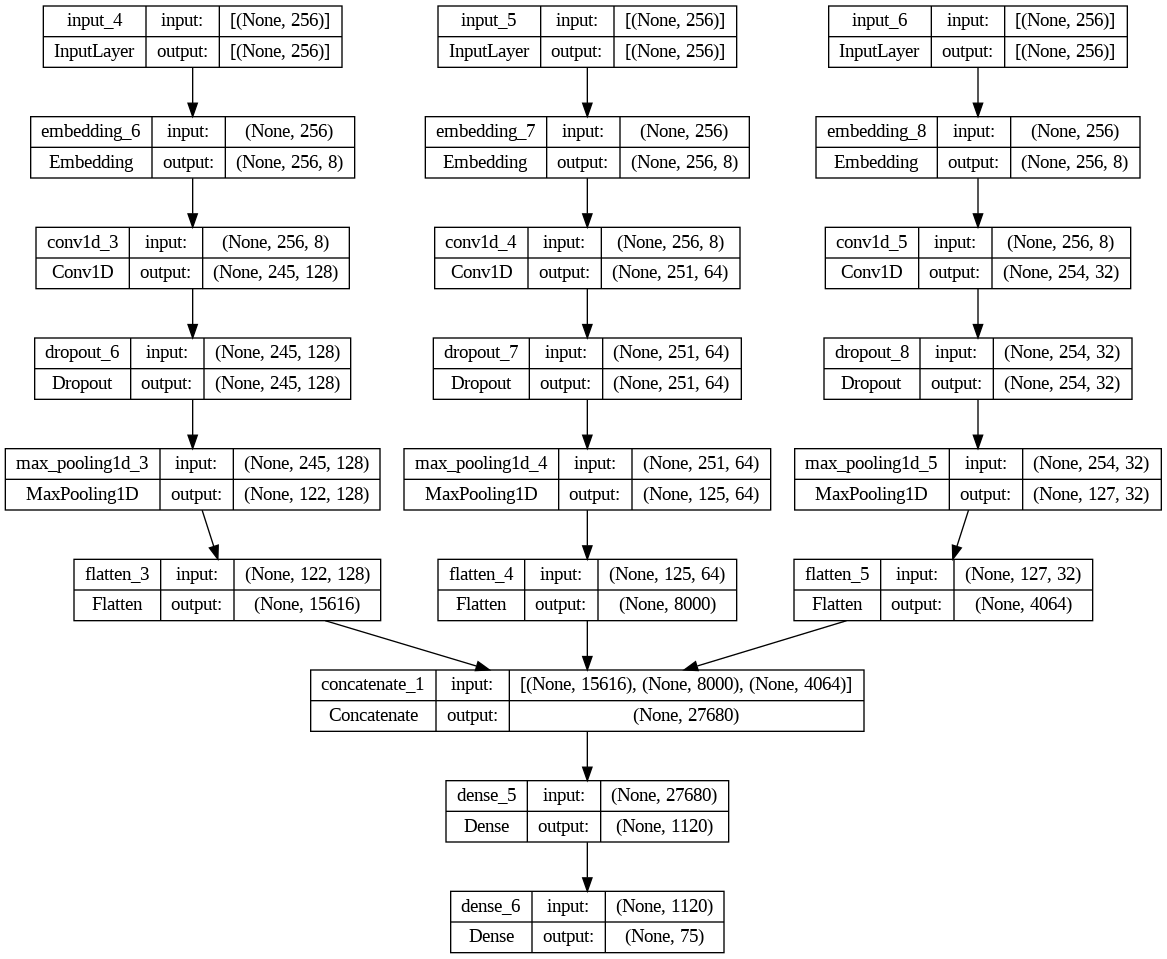

In [ ]:
plot_model(combine_model2, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/multichannel.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)
metrics_callback_cnn2 = MetricsCallback(validation_data=([X_val_256, X_val_256, X_val_256], y_val))

In [ ]:
history_combine_model2 = combine_model2.fit([X_train_256, X_train_256, X_train_256], y_train, epochs = 20, batch_size = 128, validation_data=([X_val_256, X_val_256, X_val_256], y_val), callbacks = [metrics_callback_cnn2, early_stopping], verbose = 1)


Epoch 1/20
641/641 [==============================] - 109s 169ms/step - loss: 2.4728 - accuracy: 0.3587 - val_loss: 1.7168 - val_accuracy: 0.5515
Epoch 2/20
641/641 [==============================] - 90s 140ms/step - loss: 1.6246 - accuracy: 0.5573 - val_loss: 1.3430 - val_accuracy: 0.6457
Epoch 3/20
641/641 [==============================] - 81s 127ms/step - loss: 1.0332 - accuracy: 0.7004 - val_loss: 1.2121 - val_accuracy: 0.6846
Epoch 4/20
641/641 [==============================] - 81s 126ms/step - loss: 0.6374 - accuracy: 0.8160 - val_loss: 1.2018 - val_accuracy: 0.6937
Epoch 5/20
641/641 [==============================] - 78s 122ms/step - loss: 0.4657 - accuracy: 0.8702 - val_loss: 1.2170 - val_accuracy: 0.6964
Epoch 6/20
641/641 [==============================] - 79s 123ms/step - loss: 0.3942 - accuracy: 0.8917 - val_loss: 1.1749 - val_accuracy: 0.7086
Epoch 7/20
641/641 [==============================] - 78s 122ms/step - loss: 0.3594 - accuracy: 0.8990 - val_loss: 1.2146 - val_a

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback_cnn2.epoch_accuracy)
std_accuracy = np.std(metrics_callback_cnn2.epoch_accuracy)
mean_loss = np.mean(metrics_callback_cnn2.epoch_loss)
std_loss = np.std(metrics_callback_cnn2.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback_cnn2.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback_cnn2.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback_cnn2.epoch_val_loss)
std_val_loss = np.std(metrics_callback_cnn2.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback_cnn2.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback_cnn2.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback_cnn2.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback_cnn2.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.703 ± 0.170
Training Loss (mean ± std): 0.989 ± 0.656
Validation Accuracy (mean ± std): 0.610 ± 0.045
Validation Loss (mean ± std): 1.245 ± 0.150
Validation F1 Score (weighted) (mean ± std): 0.600 ± 0.052
Validation F1 Score (macro) (mean ± std): 0.490 ± 0.081



In [ ]:
train_acc = history_combine_model2.history['accuracy']
train_loss = history_combine_model2.history['loss']

val_acc = history_combine_model2.history['val_accuracy']
val_loss = history_combine_model2.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.703 ± 0.170
Training Loss (mean ± std): 0.989 ± 0.656
Validation Accuracy (mean ± std): 0.610 ± 0.045
Validation Loss (mean ± std): 1.245 ± 0.150



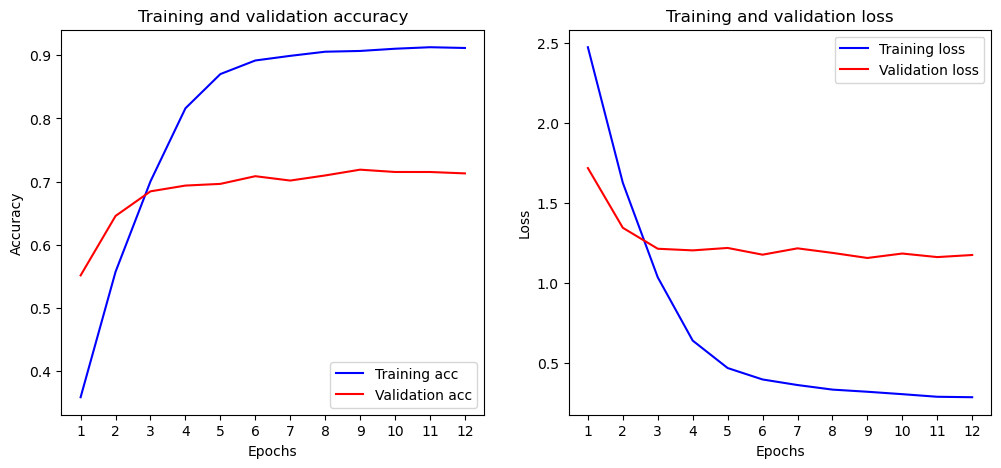

In [ ]:
plot_history(history_combine_model2)

In [ ]:
test_loss2, test_acc2 = combine_model2.evaluate([X_test_256, X_test_256, X_test_256],y_test, verbose=1)
print("Test Accuracy: ",test_acc2)
print("Test Loss: ",test_loss2)

390/390 [==============================] - 4s 11ms/step - loss: 1.7183 - accuracy: 0.5201
Test Accuracy:  0.5200809979438782
Test Loss:  1.7182905673980713



In [ ]:
train_pred_combine2 = combine_model2.predict([X_train_256, X_train_256, X_train_256])
test_pred_combine2 = combine_model2.predict([X_test_256, X_test_256, X_test_256])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_combine2, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_combine2, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_combine2, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_combine2, axis=1), average = 'macro')))

390/390 [==============================] - 4s 9ms/step
train-acc = 0.8625460579292843
test-acc = 0.5200809979438782
test f1-score = 0.4763123272801404
test f1-score (macro) = 0.41511192625466896



##### Experiment 2a with class weight

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 256

model_cnn2a = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 256, 8)       168         ['input_10[0][0]']               
                                                                                            

In [ ]:
metrics_callback_cnn2a = MetricsCallback(validation_data=([X_val_256, X_val_256, X_val_256], y_val))

history_cnn2a = model_cnn2a.fit([X_train_256, X_train_256, X_train_256], y_train, validation_data=([X_val_256, X_val_256, X_val_256], y_val), epochs=20, batch_size=128, class_weight = class_weight_dict, callbacks = [metrics_callback_cnn2a, early_stopping], verbose = 1)


Epoch 1/20
641/641 [==============================] - 104s 161ms/step - loss: 3.4367 - accuracy: 0.1118 - val_loss: 2.7787 - val_accuracy: 0.3087
Epoch 2/20
641/641 [==============================] - 94s 147ms/step - loss: 1.9579 - accuracy: 0.2921 - val_loss: 2.4899 - val_accuracy: 0.3824
Epoch 3/20
641/641 [==============================] - 91s 142ms/step - loss: 1.1190 - accuracy: 0.4417 - val_loss: 2.0440 - val_accuracy: 0.4824
Epoch 4/20
641/641 [==============================] - 81s 126ms/step - loss: 0.7889 - accuracy: 0.5553 - val_loss: 1.9061 - val_accuracy: 0.5244
Epoch 5/20
641/641 [==============================] - 79s 124ms/step - loss: 0.6068 - accuracy: 0.6427 - val_loss: 1.7577 - val_accuracy: 0.5493
Epoch 6/20
641/641 [==============================] - 82s 127ms/step - loss: 0.5164 - accuracy: 0.7004 - val_loss: 1.5537 - val_accuracy: 0.6230
Epoch 7/20
641/641 [==============================] - 80s 125ms/step - loss: 0.4492 - accuracy: 0.7442 - val_loss: 1.5066 - val_a

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback_cnn2a.epoch_accuracy)
std_accuracy = np.std(metrics_callback_cnn2a.epoch_accuracy)
mean_loss = np.mean(metrics_callback_cnn2a.epoch_loss)
std_loss = np.std(metrics_callback_cnn2a.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback_cnn2a.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback_cnn2a.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback_cnn2a.epoch_val_loss)
std_val_loss = np.std(metrics_callback_cnn2a.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback_cnn2a.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback_cnn2a.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback_cnn2a.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback_cnn2a.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.671 ± 0.219
Training Loss (mean ± std): 0.776 ± 0.828
Validation Accuracy (mean ± std): 0.579 ± 0.107
Validation Loss (mean ± std): 1.738 ± 0.396
Validation F1 Score (weighted) (mean ± std): 0.589 ± 0.108
Validation F1 Score (macro) (mean ± std): 0.515 ± 0.081


In [ ]:
train_acc = history_cnn2a.history['accuracy']
train_loss = history_cnn2a.history['loss']

val_acc = history_cnn2a.history['val_accuracy']
val_loss = history_cnn2a.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.671 ± 0.219
Training Loss (mean ± std): 0.776 ± 0.828
Validation Accuracy (mean ± std): 0.579 ± 0.107
Validation Loss (mean ± std): 1.738 ± 0.396


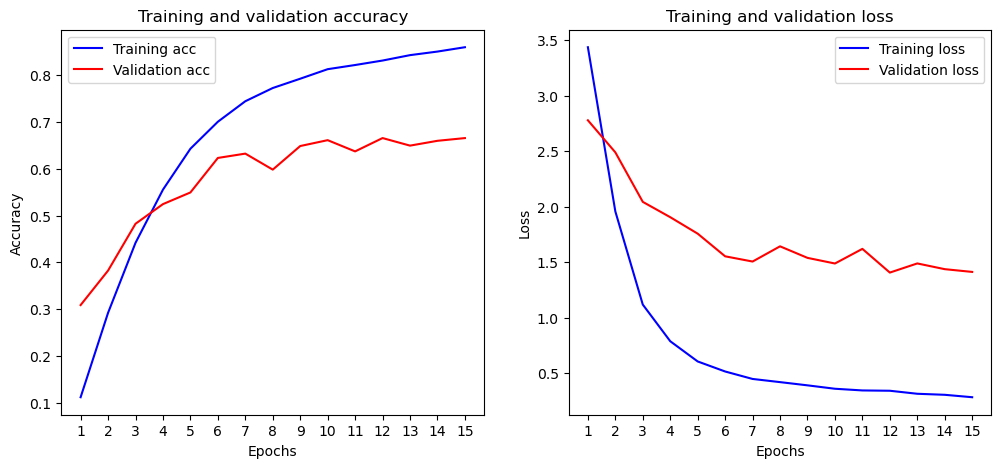

In [ ]:
plot_history(history_cnn2a)

In [ ]:
test_loss2, test_acc2 = model_cnn2a.evaluate([X_test_256, X_test_256, X_test_256],y_test, verbose=1)
print("Test Accuracy: ",test_acc2)
print("Test Loss: ",test_loss2)

390/390 [==============================] - 4s 11ms/step - loss: 1.8806 - accuracy: 0.4933
Test Accuracy:  0.4933399891853333
Test Loss:  1.8806427717208862



In [ ]:
train_pred_cnn2a = model_cnn2a.predict([X_train_256, X_train_256, X_train_256])
test_pred_cnn2a = model_cnn2a.predict([X_test_256, X_test_256,X_test_256])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_cnn2a, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_cnn2a, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_cnn2a, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_cnn2a, axis=1), average = 'macro')))

390/390 [==============================] - 4s 9ms/step
train-acc = 0.8595460579292843
test-acc = 0.4933399891853333
test f1-score = 0.4573123272801404
test f1-score (macro) = 0.40311192625466896



##### EXPERIMENT 3

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 100

combine_model3 = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 100, 8)       168         ['input_13[0][0]']               
                                                                                            

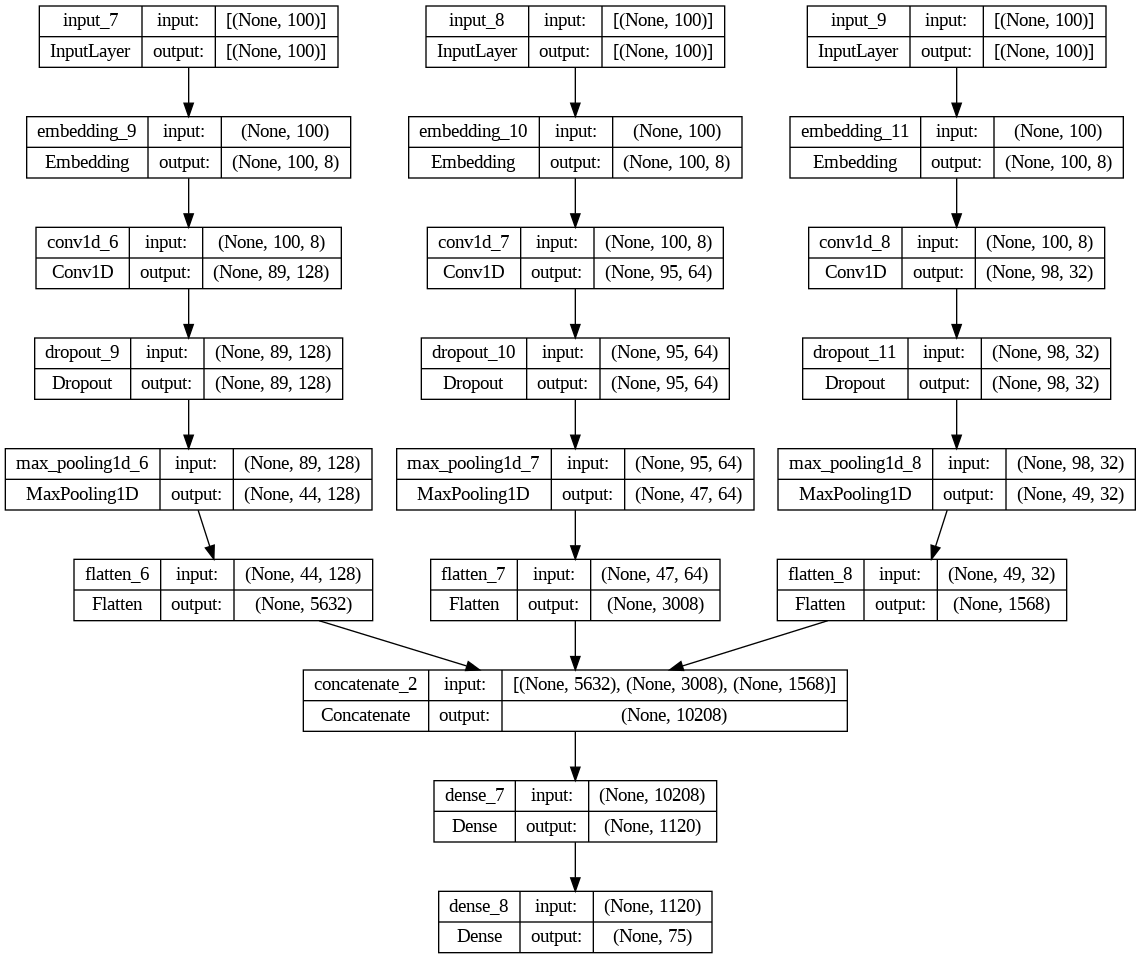

In [ ]:
plot_model(combine_model3, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/multichannel.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)
metrics_callback_cnn3 = MetricsCallback(validation_data=([X_val_100, X_val_100, X_val_100], y_val))

In [ ]:
history_combine_model3 = combine_model3.fit([X_train_100, X_train_100, X_train_100], y_train, epochs = 20, batch_size = 128, validation_data=([X_val_100, X_val_100, X_val_100], y_val), callbacks = [metrics_callback_cnn3, early_stopping], verbose = 1) #


Epoch 1/20
641/641 [==============================] - 44s 67ms/step - loss: 2.6515 - accuracy: 0.3217 - val_loss: 2.0360 - val_accuracy: 0.4683
Epoch 2/20
641/641 [==============================] - 43s 66ms/step - loss: 1.9555 - accuracy: 0.4792 - val_loss: 1.6248 - val_accuracy: 0.5793
Epoch 3/20
641/641 [==============================] - 43s 67ms/step - loss: 1.4661 - accuracy: 0.5919 - val_loss: 1.4689 - val_accuracy: 0.6191
Epoch 4/20
641/641 [==============================] - 45s 69ms/step - loss: 1.0585 - accuracy: 0.6900 - val_loss: 1.3692 - val_accuracy: 0.6462
Epoch 5/20
641/641 [==============================] - 44s 69ms/step - loss: 0.7339 - accuracy: 0.7791 - val_loss: 1.3974 - val_accuracy: 0.6433
Epoch 6/20
641/641 [==============================] - 44s 69ms/step - loss: 0.5386 - accuracy: 0.8415 - val_loss: 1.3568 - val_accuracy: 0.6633
Epoch 7/20
641/641 [==============================] - 44s 69ms/step - loss: 0.4526 - accuracy: 0.8692 - val_loss: 1.3409 - val_accuracy:

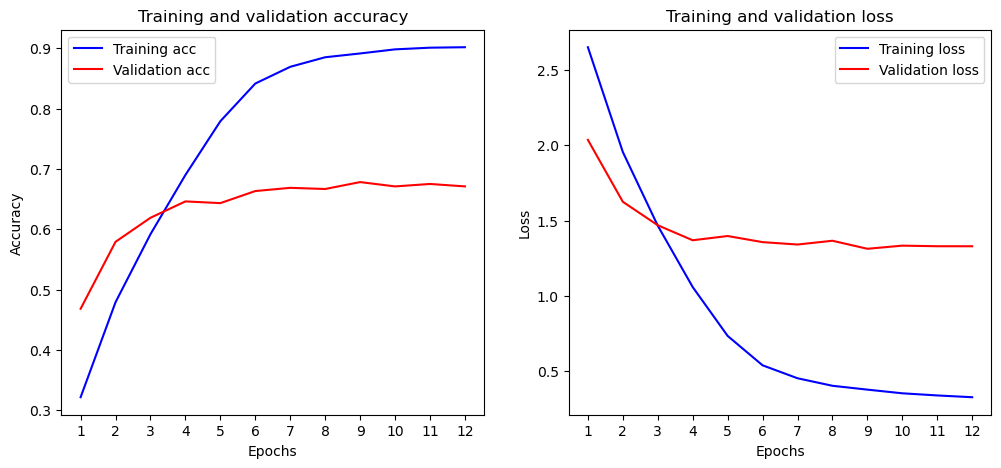

In [ ]:
plot_history(history_combine_model3)

In [ ]:
test_loss3, test_acc3 = combine_model3.evaluate([X_test_100, X_test_100, X_test_100],y_test, verbose=1)
print("Test Accuracy: ",test_acc3)
print("Test Loss: ",test_loss3)

390/390 [==============================] - 4s 10ms/step - loss: 1.8437 - accuracy: 0.5164
Test Accuracy:  0.5163713335990906
Test Loss:  1.8437092304229736



In [ ]:
train_pred_combine3 = combine_model3.predict([X_train_100, X_train_100, X_train_100])
test_pred_combine3 = combine_model3.predict([X_test_100, X_test_100, X_test_100])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_combine3, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_combine3, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_combine3, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_combine3, axis=1), average = 'macro')))

390/390 [==============================] - 2s 6ms/step
train-acc = 0.8625460579292843
test-acc = 0.5163713335990906
test f1-score = 0.4332466504855008
test f1-score (macro) = 0.36511192625492304



In [ ]:
def plot_compare_history(history1, history2, history3):
  val_acc1 = history1.history['val_accuracy'][:-5]
  val_acc2 = history2.history['val_accuracy']
  val_acc3 = history3.history['val_accuracy']
  val_loss1 = history1.history['val_loss'][:-5]
  val_loss2 = history2.history['val_loss']
  val_loss3 = history3.history['val_loss']
  x = range(1, len(val_acc1) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, val_acc1, 'b', label='val-acc 512 ')
  plt.plot(x, val_acc2, 'r', label='val-acc 256')
  plt.plot(x, val_acc3, 'g', label='val-acc 100')
  plt.title('Validation accuracy for different sequence length')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(x, val_loss1, 'b', label='val-loss 512')
  plt.plot(x, val_loss2, 'r', label='val-loss 256')
  plt.plot(x, val_loss3, 'g', label='val-loss 100')
  plt.title('Validation loss for different sequence length')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

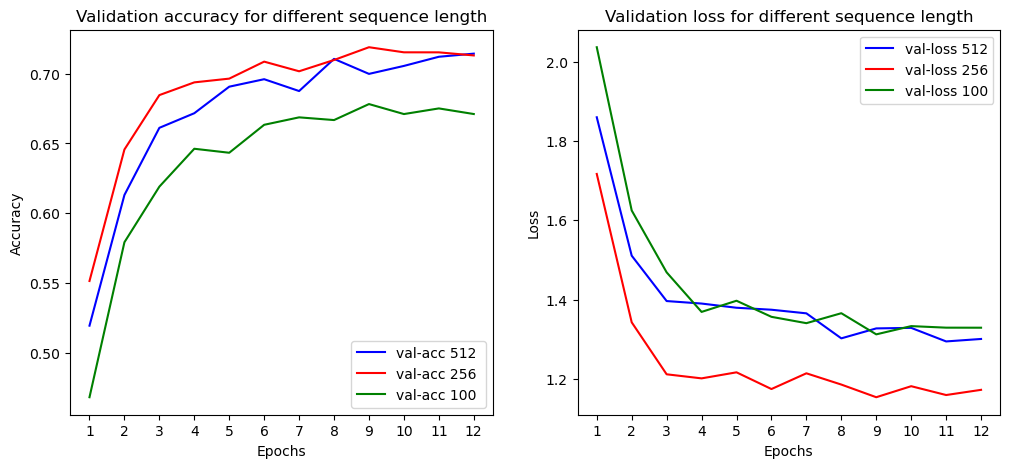

In [ ]:
plot_compare_history(history_combine_model1, history_combine_model2, history_combine_model3)

##### Experiment 3a with class weight

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 100

model_cnn3a = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 100, 8)       168         ['input_16[0][0]']               
                                                                                            

In [ ]:
metrics_callback_cnn3a = MetricsCallback(validation_data=([X_val_100, X_val_100, X_val_100], y_val))

history_cnn3a = model_cnn3a.fit([X_train_100, X_train_100, X_train_100], y_train, validation_data=([X_val_100, X_val_100, X_val_100], y_val), epochs=20, batch_size=128, class_weight = class_weight_dict, callbacks = [metrics_callback_cnn3a, early_stopping], verbose = 1)


Epoch 1/20
641/641 [==============================] - 48s 74ms/step - loss: 3.6259 - accuracy: 0.0838 - val_loss: 3.0928 - val_accuracy: 0.2390
Epoch 2/20
641/641 [==============================] - 47s 73ms/step - loss: 2.3144 - accuracy: 0.2110 - val_loss: 2.8164 - val_accuracy: 0.2991
Epoch 3/20
641/641 [==============================] - 46s 72ms/step - loss: 1.4920 - accuracy: 0.3121 - val_loss: 2.5646 - val_accuracy: 0.3596
Epoch 4/20
641/641 [==============================] - 46s 72ms/step - loss: 1.0589 - accuracy: 0.4045 - val_loss: 2.3368 - val_accuracy: 0.4052
Epoch 5/20
641/641 [==============================] - 46s 72ms/step - loss: 0.8237 - accuracy: 0.4828 - val_loss: 2.0040 - val_accuracy: 0.4803
Epoch 6/20
641/641 [==============================] - 46s 72ms/step - loss: 0.6731 - accuracy: 0.5465 - val_loss: 1.9737 - val_accuracy: 0.4849
Epoch 7/20
641/641 [==============================] - 46s 72ms/step - loss: 0.5779 - accuracy: 0.5973 - val_loss: 1.8176 - val_accuracy:

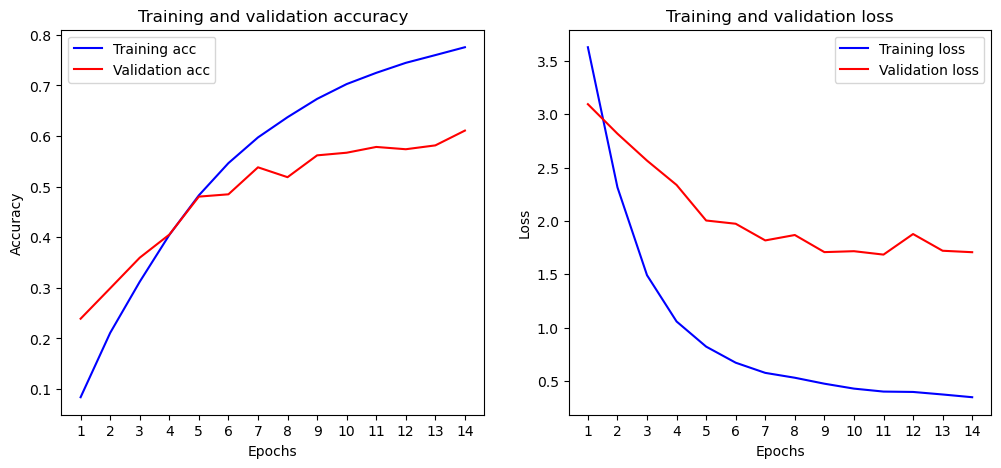

In [ ]:
plot_history(history_cnn3a)

In [ ]:
test_loss3, test_acc3 = model_cnn3a.evaluate([X_test_100, X_test_100, X_test_100],y_test, verbose=1)
print("Test Accuracy: ",test_acc3)
print("Test Loss: ",test_loss3)

390/390 [==============================] - 4s 10ms/step - loss: 2.2240 - accuracy: 0.4525
Test Accuracy:  0.4524885940551758
Test Loss:  2.223968505859375



In [ ]:
train_pred_cnn3a = model_cnn3a.predict([X_train_100, X_train_100, X_train_100])
test_pred_cnn3a = model_cnn3a.predict([X_test_100, X_test_100, X_test_100])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_cnn3a, axis=1), np.argmax(y_train, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_cnn3a, axis=1), np.argmax(y_test, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_cnn3a, axis=1), average = 'weighted')))
print("test f1-score (macro) = " + str(f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred_cnn3a, axis=1), average = 'macro')))


390/390 [==============================] - 3s 6ms/step
train-acc = 0.77563421478654
test-acc = 0.4524885940551758
test f1-score = 0.4063183062260656
test f1-score (macro) = 0.335188575322697



In [ ]:
def plot_compare_history1(history1, history2, history3):
  val_acc1 = history1.history['val_accuracy']
  val_acc2 = history2.history['val_accuracy'][:-4]
  val_acc3 = history3.history['val_accuracy'][:-3]
  val_loss1 = history1.history['val_loss']
  val_loss2 = history2.history['val_loss'][:-4]
  val_loss3 = history3.history['val_loss'][:-3]
  x = range(1, len(val_acc3) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, val_acc1, 'b', label='val-acc 512 ')
  plt.plot(x, val_acc2, 'r', label='val-acc 256')
  plt.plot(x, val_acc3, 'g', label='val-acc 100')
  plt.title('Validation accuracy for different sequence length')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(x, val_loss1, 'b', label='val-loss 512')
  plt.plot(x, val_loss2, 'r', label='val-loss 256')
  plt.plot(x, val_loss3, 'g', label='val-loss 100')
  plt.title('Validation loss for different sequence length')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

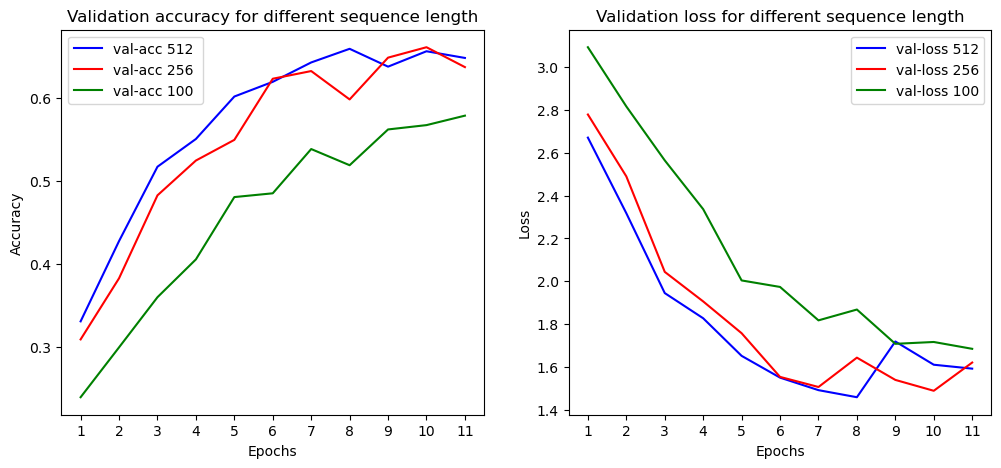

In [ ]:
plot_compare_history1(history_cnn1a, history_cnn2a, history_cnn3a)

### Comparing Models

In [ ]:
# without seq similarity
# cnn_acc = [0.65, 0.67, 0.66]
# cnn_macro_f1 = [0.50, 0.55, 0.55]
# cnn_weighted_f1 = [0.64, 0.66, 0.66]
# lstm_acc = [0.51, 0.49, 0.41]
# lstm_macro_f1 = [0.32, 0.28, 0.16]
# lstm_weighted_f1 = [0.48, 0.46, 0.36]
# length = [100, 256, 512]
# cnn_acc_cw = [0.60, 0.61, 0.62]
# cnn_macro_f1_cw = [0.52, 0.53, 0.53]
# cnn_weighted_f1_cw = [0.61, 0.62, 0.63]

# with ecod family
cnn_acc = [0.52, 0.52, 0.50]
cnn_macro_f1 = [0.43, 0.48, 0.47]
cnn_weighted_f1 = [0.37, 0.42, 0.41]
lstm_acc = [0.44, 0.40, 0.39]
lstm_macro_f1 = [0.29, 0.25, 0.16]
lstm_weighted_f1 = [0.37, 0.37, 0.34]
length = [100, 256, 512]
cnn_acc_cw = [0.45, 0.49, 0.49]
cnn_macro_f1_cw = [0.41, 0.46, 0.46]
cnn_weighted_f1_cw = [0.34, 0.40, 0.39]

In [ ]:
dl_df2 = pd.DataFrame({'cnn accuracy': cnn_acc, 'cnn macro f1': cnn_macro_f1, 'cnn weighted f1': cnn_weighted_f1,
                       'cnn acc with cw': cnn_acc_cw, 'cnn macro f1 with cw': cnn_macro_f1_cw, 'cnn weighted f1 with cw': cnn_weighted_f1_cw,
                       'lstm accuracy': lstm_acc, 'lstm macro f1': lstm_macro_f1, 'lstm weighted f1': lstm_weighted_f1}, index=length)

dl_df2

,cnn accuracy,cnn macro f1,cnn weighted f1,cnn acc with cw,cnn macro f1 with cw,cnn weighted f1 with cw,lstm accuracy,lstm macro f1,lstm weighted f1
100,0.52,0.43,0.37,0.45,0.41,0.34,0.44,0.29,0.37
256,0.52,0.48,0.42,0.49,0.46,0.40,0.40,0.25,0.37
512,0.50,0.47,0.41,0.49,0.46,0.39,0.39,0.16,0.34


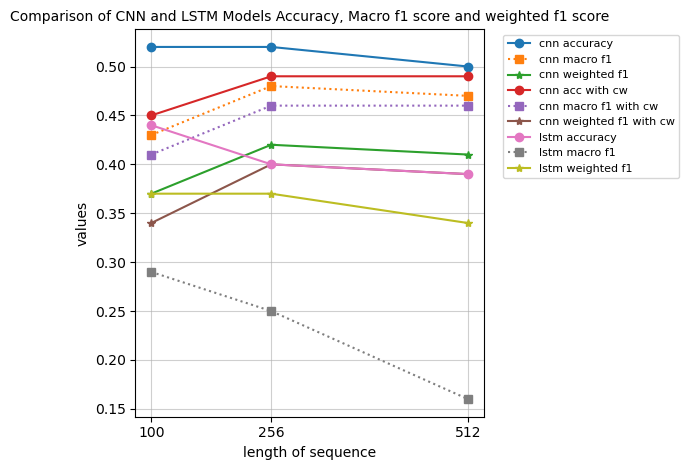

In [ ]:
# plt.figure(figsize = (10,6))
ax = dl_df2.plot(kind = 'line', style=['o-','s:', '*-', 'o-','s:', '*-', 'o-','s:', '*-'])
ax.legend(
    bbox_to_anchor=(1.04, 1),
    prop={'size': 8}
)
plt.grid(alpha = 0.6)
plt.xticks([100, 256, 512])
plt.title("Comparison of CNN and LSTM Models Accuracy, Macro f1 score and weighted f1 score",fontsize=10)
plt.xlabel('length of sequence')
plt.ylabel('values')
plt.tight_layout()
# plt.savefig('pdb_comparison_cnnlstm_model.jpg', dpi = 300, bbox_inches='tight')
plt.show()

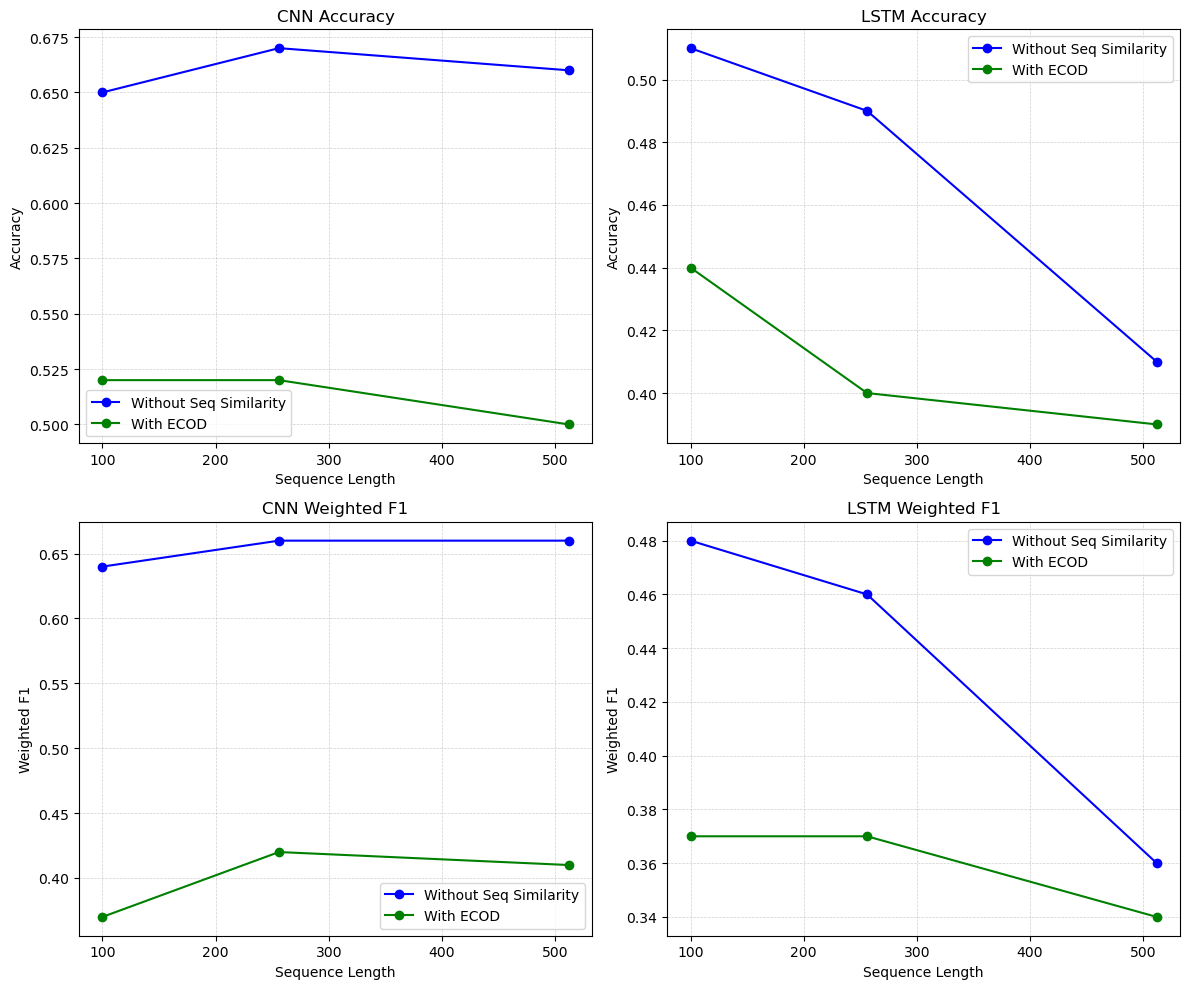

In [ ]:
# Re-importing necessary libraries after reset
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
length = [100, 256, 512]

# Without sequence similarity
cnn_acc_wo = [0.65, 0.67, 0.66]
cnn_macro_f1_wo = [0.50, 0.55, 0.55]
cnn_weighted_f1_wo = [0.64, 0.66, 0.66]
lstm_acc_wo = [0.51, 0.49, 0.41]
lstm_macro_f1_wo = [0.32, 0.28, 0.16]
lstm_weighted_f1_wo = [0.48, 0.46, 0.36]
cnn_acc_cw_wo = [0.60, 0.61, 0.62]
cnn_macro_f1_cw_wo = [0.52, 0.53, 0.53]
cnn_weighted_f1_cw_wo = [0.61, 0.62, 0.63]

# with ecod family
cnn_acc_w = [0.52, 0.52, 0.50]
cnn_macro_f1_w = [0.43, 0.48, 0.47]
cnn_weighted_f1_w = [0.37, 0.42, 0.41]
lstm_acc_w = [0.44, 0.40, 0.39]
lstm_macro_f1_w = [0.29, 0.25, 0.16]
lstm_weighted_f1_w = [0.37, 0.37, 0.34]
cnn_acc_cw_w = [0.45, 0.49, 0.49]
cnn_macro_f1_cw_w = [0.41, 0.46, 0.46]
cnn_weighted_f1_cw_w = [0.34, 0.40, 0.39]

# Set up the plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# CNN Accuracy Plot
axs[0, 0].plot(length, cnn_acc_wo, label="Without Seq Similarity", marker='o', color='b')
axs[0, 0].plot(length, cnn_acc_w, label="With ECOD", marker='o', color='g')
axs[0, 0].set_title('CNN Accuracy')
axs[0, 0].set_xlabel('Sequence Length')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(alpha=0.6, linestyle='--', linewidth=0.5)

# LSTM Accuracy Plot
axs[0, 1].plot(length, lstm_acc_wo, label="Without Seq Similarity", marker='o', color='b')
axs[0, 1].plot(length, lstm_acc_w, label="With ECOD", marker='o', color='g')
axs[0, 1].set_title('LSTM Accuracy')
axs[0, 1].set_xlabel('Sequence Length')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid(alpha=0.6, linestyle='--', linewidth=0.5)

# CNN Weighted F1 Plot
axs[1, 0].plot(length, cnn_weighted_f1_wo, label="Without Seq Similarity", marker='o', color='b')
axs[1, 0].plot(length, cnn_weighted_f1_w, label="With ECOD", marker='o', color='g')
axs[1, 0].set_title('CNN Weighted F1')
axs[1, 0].set_xlabel('Sequence Length')
axs[1, 0].set_ylabel('Weighted F1')
axs[1, 0].legend()
axs[1, 0].grid(alpha=0.6, linestyle='--', linewidth=0.5)

# LSTM Weighted F1 Plot
axs[1, 1].plot(length, lstm_weighted_f1_wo, label="Without Seq Similarity", marker='o', color='b')
axs[1, 1].plot(length, lstm_weighted_f1_w, label="With ECOD", marker='o', color='g')
axs[1, 1].set_title('LSTM Weighted F1')
axs[1, 1].set_xlabel('Sequence Length')
axs[1, 1].set_ylabel('Weighted F1')
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.6, linestyle='--', linewidth=0.5)

# Adjust layout for better visibility
plt.tight_layout()

plt.savefig("figure3.tiff", format="tiff", dpi=300, bbox_inches='tight', transparent=False)

plt.show()
